<a href="https://colab.research.google.com/github/marianecosta/teste-estrategia-ssl-ema/blob/main/Teste_estrategia_ssl_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install backtrader

     |████████████████████████████████| 410 kB 7.3 MB/s 


In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 10.0 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


Valor Inicial: 1000.00
Initial portfolio value: 1000.0
Final   portfolio value: 10106.229999999996
Return rate: 10.106229999999996
Valor Final: 10106.23


<IPython.core.display.Javascript object>

[[<Figure size 4608x3456 with 3 Axes>]]

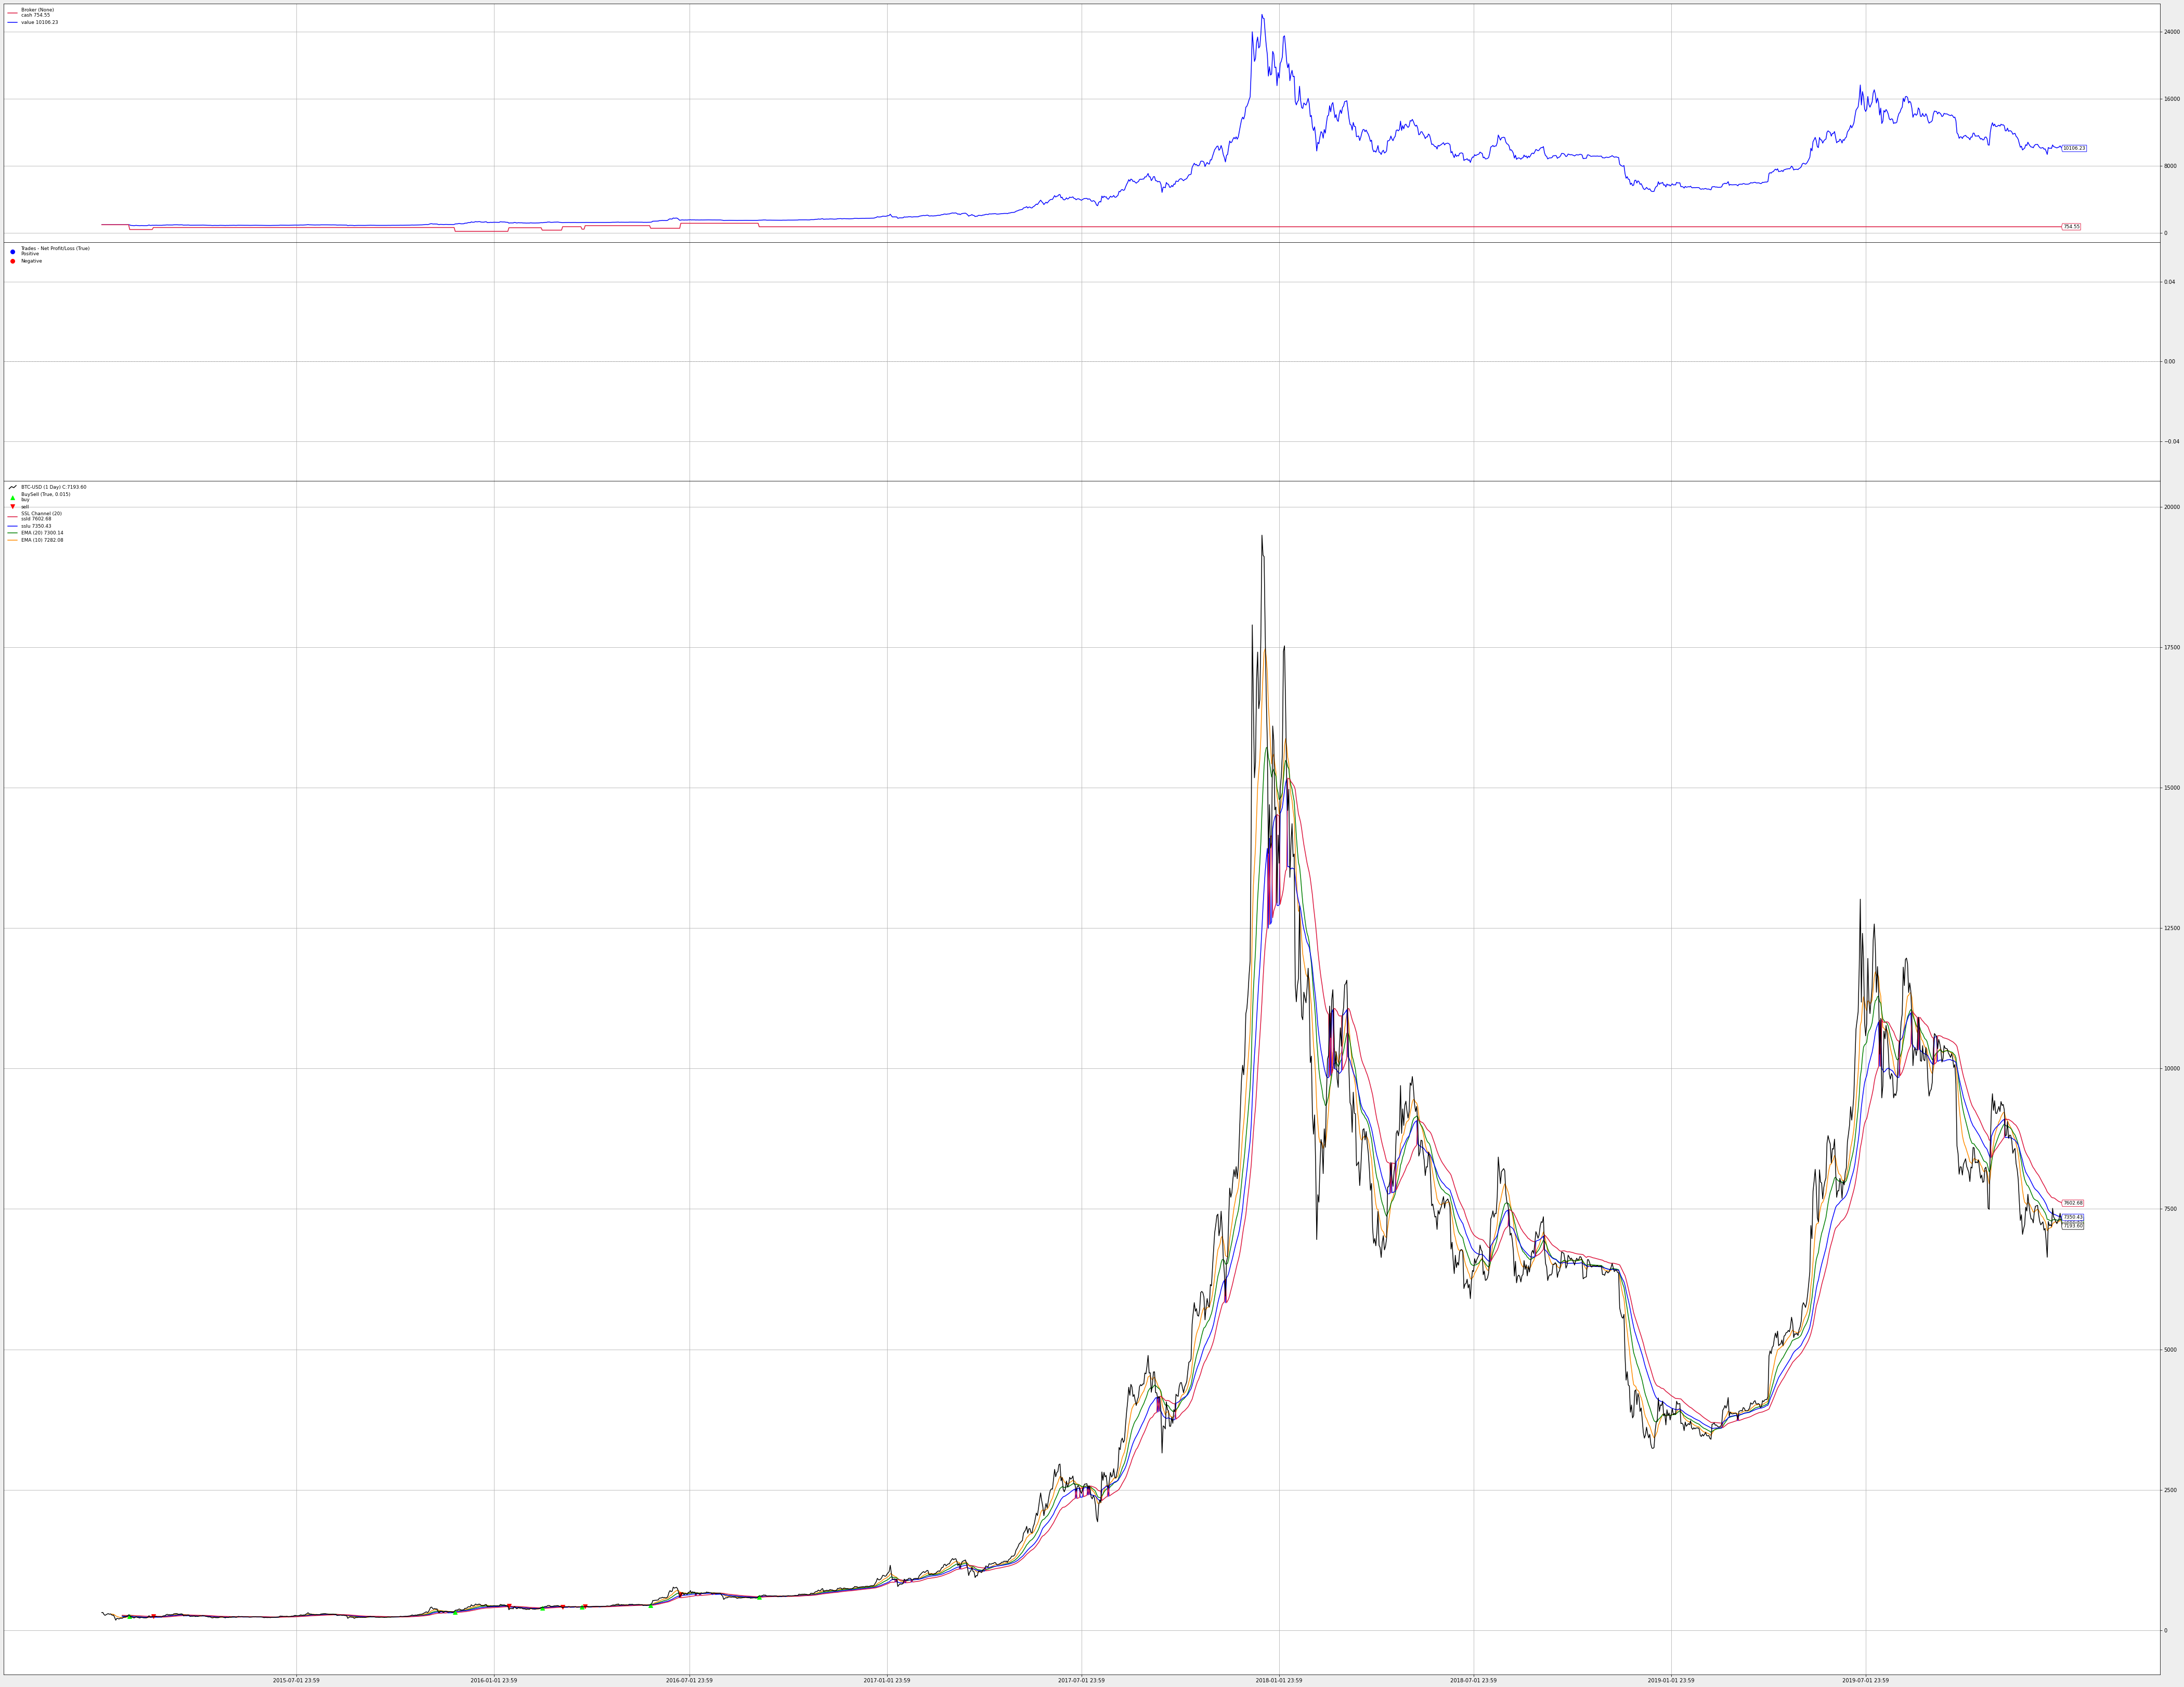

In [ ]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import backtrader as bt
import yfinance as yf
from datetime import datetime
import backtrader.feeds as btfeeds
import backtrader.indicators as btind
from backtrader.indicators import EMA
from google.colab import files
from IPython.display import Image

# Plot
%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 64,48
rcParams['figure.facecolor'] = '#eeeeee'
plt.title('dummy')
plt.plot([1,3,2,4])
plt.close()

# Adiciona o indicador SSL Channel
class SSLChannel(bt.Indicator):
    lines = ('ssld', 'sslu')
    params = (('period', 30),)
    plotinfo = dict(
        plot=True,
        plotname='SSL Channel',
        subplot=False,
        plotlinelabels=True)

    def _plotlabel(self):
        return [self.p.period]

    def __init__(self):
        self.addminperiod(self.p.period)
        self.hma_lo = bt.indicators.SmoothedMovingAverage(self.data.low, period=self.p.period)
        self.hma_hi = bt.indicators.SmoothedMovingAverage(self.data.high, period=self.p.period)

    def next(self):
        hlv = 1 if self.data.close > self.hma_hi[0] else -1
        if hlv == -1:
            self.lines.ssld[0] = self.hma_hi[0]
            self.lines.sslu[0] = self.hma_lo[0]

        elif hlv == 1:
            self.lines.ssld[0] = self.hma_lo[0]
            self.lines.sslu[0] = self.hma_hi[0]

# Início da estratégia
'''
Entrada = Ema 10 acima da ema 20 e acima do indicator SSL Channel.
Saída = Contrário da entrada.
'''
class Strategy(bt.SignalStrategy):

    def __init__(self):
        self.order_id = None
        self.status = 0
        self.portfolio_value = 1000  #Valor inicial
        self.exchange_amt = .7
        self.st = SSLChannel(period=20)  #Período do indicador SSL
        self.ema20 = EMA(self.data, period=20)
        self.ema10 = EMA(self.data, period=10)

    def notify_order(self, order):
        if order.status in [bt.Order.Submitted, bt.Order.Accepted]:
            return

        self.order_id = None

    def next(self):

        if self.order_id:
            return
     
        if (self.data.close < self.st) and (self.ema20 < self.ema10) and (self.status != 1) :
            numShares = (self.broker.getvalue() - self.broker.getcash())/self.data.close
            numToSell = int(numShares*self.exchange_amt)
            self.sell(data=self.data, size=numToSell)
            self.status = 1

        if (self.data.close > self.st) and (self.ema20 > self.ema10) and (self.status != 2) :
            numSharesToBuy = int(self.broker.getcash() / self.data.close) * self.exchange_amt
            self.buy(data=self.data, size=numSharesToBuy)
            self.status = 2
            
    def stop(self):
        self.sell(data=self.data, size=(self.broker.getvalue()))
        print(f'Initial portfolio value: {self.broker.startingcash}')
        print(f'Final   portfolio value: {self.broker.getvalue()}')
        # print(f'Final    cash amout    : {self.broker.getcash()}')
        print(
            f'Return rate: {(self.broker.getvalue())/self.broker.startingcash}'
        )

# Cria a instância do cerebro
cerebro = bt.Cerebro()

cerebro.addstrategy(Strategy)

data = bt.feeds.YahooFinanceData(dataname='BTC-USD.csv',
                              fromdate=datetime(2015, 1, 1),
                              todate=datetime(2020, 1, 1))
# Valor do capital inicial
startcash = 1000

cerebro.adddata(data)
    
# Valor inicial
cerebro.broker.setcash(1000.0)

print('Valor Inicial: %.2f' % cerebro.broker.getvalue())

# Percorre
cerebro.run()

print('Valor Final: %.2f' % cerebro.broker.getvalue())

cerebro.plot(iplot=True, volume=False)
